In [30]:
import os
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings('error', category=DeprecationWarning)
import pandas as pd
import numpy as np
from numpy import int64
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
import seaborn as sns
import pandas as pd
import cv2
from stable_baselines3 import PPO                                                    
import gym   
import gym_md
import matplotlib.gridspec as gridspec
import imageio
# %pip install seaborn
from IPython.display import Image as IImg, display

In [31]:
def get_exp_details(name):
    config = {}
    var = name.split('_')
    # print(var)
    if len(var[1])==1 and var[2]=='not':
        # print("len(var[1])==1 and var[2]!='not'")
        # check_1_not_original_clearer_risky_baseline
        # check_1_original_optimal_baseline
        config['lvl'] = f"{var[0]}_{var[1]}"
        config['reward_scheme'] = f"{var[2]}_{var[3]}"
        config['play_style'] = f"{var[4]}_{var[5]}"
        config['exp_type'] = var[6]
    # elif len(var[1])==1 and 'not' in var and 'optimal' in var: 
    #     # check_1_not_original_clearer_risky_baseline
    #     # print("len(var[1])==1 and 'not' in var and 'optimal' in var")
    #     config['lvl'] = f"{var[0]}_{var[1]}"
    #     config['reward_scheme'] = f"{var[2]}_{var[3]}"
    #     config['play_style'] = f"{var[4]}_{var[5]}"
    #     config['exp_type'] = var[6]
    elif len(var[1])==1 and var[2]!='not':
        # print("len(var[1])==1 and 'not' not in var and 'optimal' not in var")
        # check_1_not_original_clearer_risky_baseline
        # check_1_original_optimal_baseline
        # 'policy_1_treasure_fifty_twoFifty_rewardShaping_6'
        config['lvl'] = f"{var[0]}_{var[1]}"
        config['reward_scheme'] = var[2]
        config['play_style'] = var[3]
        config['exp_type'] = var[4]
    elif len(var[1])!=1 and var[2]=='not':
        # hard_not_original_clearer
        config['lvl'] = var[0]
        config['reward_scheme'] = f"{var[1]}_{var[2]}"
        config['play_style'] = f"{var[3]}_{var[4]}"
        config['exp_type'] = var[5]
    else:
        print("else")
        # hard_not_original_clearer_safe_baseline
        config['lvl'] = var[0]
        config['reward_scheme'] = var[1]
        config['play_style'] = var[2]
        config['exp_type'] = var[3]

    # print(config)
    return config


def get_reshape(row):
    # print(row)
    return np.fromstring(row['grid'].replace('\n','')
                .replace('[','')
                .replace(']','')
                .replace('  ',' '), sep=' ').reshape(row['grid_rows'],row['grid_columns'])

def gen_heatmap(df,f):
    df = df.reset_index()
    x_array = df['x'].to_numpy()
    y_array =df['y'].to_numpy()
    grid = np.zeros((df['grid_rows'][0],df['grid_columns'][0]))
    for i, j in zip(y_array,x_array):
        grid[i,j]+=1
    heat =sns.heatmap(grid,cmap='viridis',alpha =0.6,zorder=2)
    my_image = cv2.imread(f)
    my_image = cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
    # plt.imshow(my_image)
    plt.title(df['experiment'][0])
    img = heat.imshow(my_image,aspect=heat.get_aspect(),extent= heat.get_xlim() + heat.get_ylim(),zorder=1)
    return img

def gen_data(lvl,reward_scheme, play_style,exp_type,path):   
    data =[]
    exp_type =exp_type
    lvl =lvl
    play_style= play_style
    reward_scheme=reward_scheme
    env = gym.make(f"md-{lvl}-v0")
    env.setting.IS_ENEMY_POWER_RANDOM =False
    if play_style=='killer':
        env.setting.PLAYER_MAX_HP = 10000

                                                                
    # model = PPO(policy = "MlpPolicy",env =  env, verbose=1,device="cuda") 
    print(exp_type)
    exp = f"{lvl}_{play_style}_{reward_scheme}_{exp_type}"
    exp= exp
    print(exp)
    model = PPO.load(f"logs/{path}/{exp}/best_model/best_model")  # loading the model from ppo_cartpole.zip             
                                                                                            
    obs = env.reset()  
    for ep in range(5):                                                                    
        for i in range(1000):                                                                   
            action, _state = model.predict(obs, deterministic=False)                             
            obs, reward, done, info = env.step(action) 
            grid= np.array(env.grid.g)  
            data.append([exp, lvl, i, env.agent.x, env.agent.y, grid, play_style, info['action_taken'], obs, done, reward, dict(info),grid.shape[0],grid.shape[1]])
                                                
            # env.render(mode='human')                                                                        
            if done:                                                                            
                obs = env.reset()
                break
                
    return data

def gen_data_and_img(lvl,reward_scheme, play_style,exp_type,path, img_path):
    data =gen_data(lvl,reward_scheme, play_style,exp_type,path)
    df = pd.DataFrame(data, columns=['experiment','level','run','x','y','grid','play_style','action','observation','done','reward','info','grid_rows','grid_columns'])

    img =gen_heatmap(df, img_path)
    return img

# def fig2array(fig):
#     canvas = FigureCanvas(fig)
#     # Force a draw so we can grab the pixel buffer
#     canvas.draw()
#     # grab the pixel buffer and dump it into a numpy array
#     return np.array(canvas.renderer.buffer_rgba())

# def saveAndDisplayGIF(sequence, outputName="sequence.gif", FPS=5):
#     with imageio.get_writer(outputName, mode='I', fps=FPS) as writer:
#         for frame in sequence:
#             writer.append_data(frame)
#     display(IImg("../working/"+outputName))

In [11]:
data =gen_data("policy_1", play_style="treasure", reward_scheme="fifty_twoFifty", exp_type="rewardShaping_6", path="reward_shaping")
df = pd.DataFrame(data, columns=['experiment','level','run','x','y','grid','play_style','action','observation','done','reward','info','grid_rows','grid_columns'])
# df['grid'] = df[['grid','grid_rows','grid_columns']].apply(lambda x: get_reshape(x),axis=1)
# df.dtypes
df
# dirs =os.listdir('./logs/Baseline/')
# models = []
# for i in dirs:
#     models.append(str(i))
# models = sorted(models)
# print(models)
# 'policy_1_treasure_fifty_twoFifty_rewardShaping_6'

rewardShaping_6
policy_1_treasure_fifty_twoFifty_rewardShaping_6


/home/alex/anaconda3/envs/test1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/alex/anaconda3/envs/test1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


,experiment,level,run,x,y,grid,play_style,action,observation,done,reward,info,grid_rows,grid_columns
0,policy_1_treasure_fifty_twoFifty_rewardShaping_6,policy_1,0,0,8,"[[2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2]...",treasure,TREASURE_SAFELY,"[4, 4, 4, 6, 6, 8, 8, 5]",False,-1.0,"{'action_taken': 'TREASURE_SAFELY', 'TREASURE_...",15,15
1,policy_1_treasure_fifty_twoFifty_rewardShaping_6,policy_1,1,0,7,"[[2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2]...",treasure,MONSTER,"[3, 3, 3, 5, 5, 7, 7, 5]",False,-1.0,"{'action_taken': 'MONSTER', 'TREASURE_SAFELY':...",15,15
2,policy_1_treasure_fifty_twoFifty_rewardShaping_6,policy_1,2,0,6,"[[2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2]...",treasure,TREASURE_SAFELY,"[4, 2, 2, 6, 6, 8, 8, 5]",False,-1.0,"{'action_taken': 'TREASURE_SAFELY', 'TREASURE_...",15,15
3,policy_1_treasure_fifty_twoFifty_rewardShaping_6,policy_1,3,0,5,"[[2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2]...",treasure,TREASURE,"[5, 1, 1, 7, 7, 9, 9, 5]",False,-1.0,"{'action_taken': 'TREASURE', 'TREASURE_SAFELY'...",15,15
4,policy_1_treasure_fifty_twoFifty_rewardShaping_6,policy_1,4,0,4,"[[2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2]...",treasure,TREASURE_SAFELY,"[6, 0, 0, 8, 8, 10, 10, 5]",False,4.0,"{'action_taken': 'TREASURE_SAFELY', 'TREASURE_...",15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,policy_1_treasure_fifty_twoFifty_rewardShaping_6,policy_1,66,9,7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",treasure,EXIT,"[3, 1000, 1000, 2, 2, 2, 2, 5]",False,-1.0,"{'action_taken': 'EXIT', 'TREASURE_SAFELY': 18...",15,15
299,policy_1_treasure_fifty_twoFifty_rewardShaping_6,policy_1,67,8,7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",treasure,EXIT_SAFELY,"[4, 1000, 1000, 3, 3, 1, 1, 5]",False,-1.0,"{'action_taken': 'EXIT_SAFELY', 'TREASURE_SAFE...",15,15
300,policy_1_treasure_fifty_twoFifty_rewardShaping_6,policy_1,68,9,7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",treasure,POTION,"[3, 1000, 1000, 2, 2, 2, 2, 5]",False,-1.0,"{'action_taken': 'POTION', 'TREASURE_SAFELY': ...",15,15
301,policy_1_treasure_fifty_twoFifty_rewardShaping_6,policy_1,69,8,7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",treasure,EXIT,"[4, 1000, 1000, 3, 3, 1, 1, 5]",False,-1.0,"{'action_taken': 'EXIT', 'TREASURE_SAFELY': 18...",15,15


In [8]:
dirs =os.listdir('./logs/reward_shaping/')
models = []
for i in dirs:
    models.append(str(i))
models = sorted(models)
print(models)

['check_1_killer_fifty_twoFifty_rewardShaping', 'check_1_killer_fiftytwoFifty_rewardShapingKillerLonger', 'check_1_potion_fifty_twoFifty_rewardShaping', 'check_1_runner_fifty_twoFifty_rewardShaping', 'check_1_treasure_fifty_twoFifty_rewardShaping', 'check_1_treasure_fifty_twoFifty_rewardShaping_1', 'hard_killer_fifty_twoFifty_rewardShaping', 'hard_killer_fiftytwoFifty_rewardShapingKillerLonger', 'hard_potion_fifty_twoFifty_rewardShaping', 'hard_runner_fifty_twoFifty_rewardShaping', 'hard_treasure_fifty_twoFifty_rewardShaping', 'holmgard_9_killer_fifty_twoFifty_rewardShaping', 'holmgard_9_killer_fiftytwoFifty_rewardShapingKillerLonger', 'holmgard_9_potion_fifty_twoFifty_rewardShaping', 'holmgard_9_runner_fifty_twoFifty_rewardShaping', 'holmgard_9_treasure_fifty_twoFifty_rewardShaping', 'policy_1_killer_fifty_twoFifty_rewardShaping', 'policy_1_killer_fifty_twoFifty_rewardShaping_1', 'policy_1_killer_fifty_twoFifty_rewardShaping_2', 'policy_1_killer_fiftytwoFifty_rewardShapingKillerLonger

{'lvl': 'check_1', 'reward_scheme': 'killer', 'play_style': 'fifty', 'exp_type': 'twoFifty'}
rewardShaping_6
policy_1_treasure_fifty_twoFifty_rewardShaping_6


/home/alex/anaconda3/envs/test1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/alex/anaconda3/envs/test1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


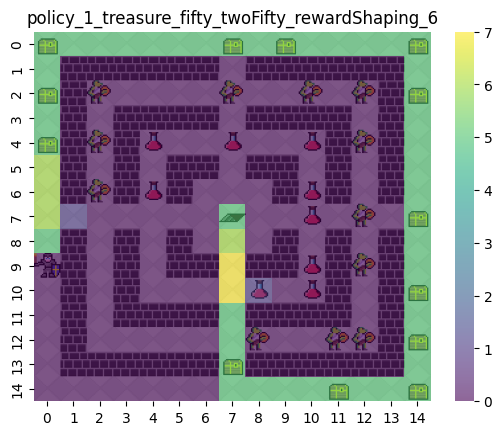

In [18]:
config = get_exp_details(models[0])
lvl ='policy_1'
# lvl= co
print(config)
# treasure1 =gen_data_and_img(lvl='policy_1',reward_scheme='fifty_twoFifty', play_style='treasure',exp_type='rewardShaping_6',path='reward_shaping', img_path='.')
# try:
#     # gen_data_and_img(lvl='policy_1',reward_scheme='fifty_twoFifty', play_style='treasure',exp_type='rewardShaping_6',path='reward_shaping',img_path=f'./README/resources/md_stages_screenshots/md-{lvl}-v0_step0.jpg')
# except:
gen_data_and_img(lvl='policy_1',reward_scheme='fifty_twoFifty', play_style='treasure',exp_type='rewardShaping_6',path='reward_shaping',img_path=f'./README/resources/md_stages_screenshots/md-{lvl}-v0_step0.png')

rewardShaping
policy_1_potion_fifty_twoFifty_rewardShaping


/home/alex/anaconda3/envs/test1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/alex/anaconda3/envs/test1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


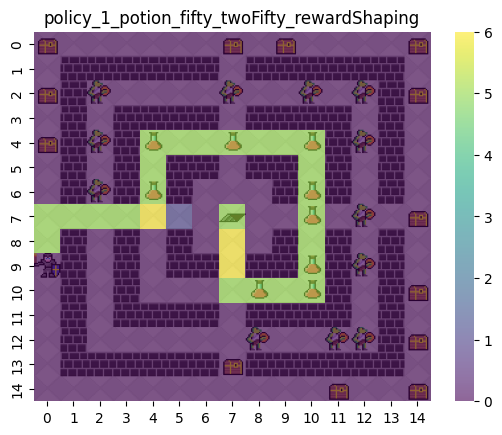

In [26]:
gen_data_and_img(lvl='policy_1',reward_scheme='fifty_twoFifty', play_style='potion',exp_type='rewardShaping',path='reward_shaping',img_path=f'./README/resources/md_stages_screenshots/md-{lvl}-v0_step0.png')


rewardShaping_2
policy_1_killer_fifty_twoFifty_rewardShaping_2


/home/alex/anaconda3/envs/test1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/alex/anaconda3/envs/test1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


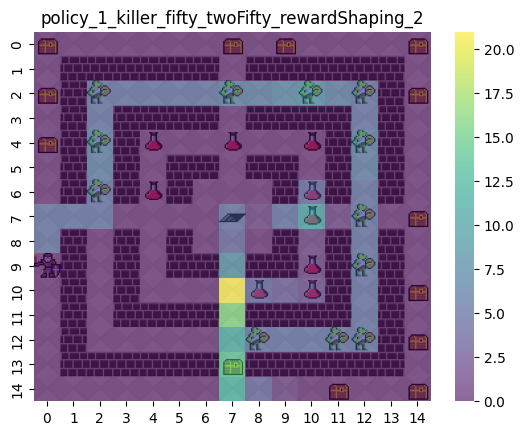

In [46]:
lvl= 'policy_1'
gen_data_and_img(lvl='policy_1',reward_scheme='fifty_twoFifty', play_style='killer',exp_type='rewardShaping_2',path='reward_shaping',img_path=f'./README/resources/md_stages_screenshots/md-{lvl}-v0_step0.png')


rewardShaping_1
check_1_treasure_fifty_twoFifty_rewardShaping_1


/home/alex/anaconda3/envs/test1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/alex/anaconda3/envs/test1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


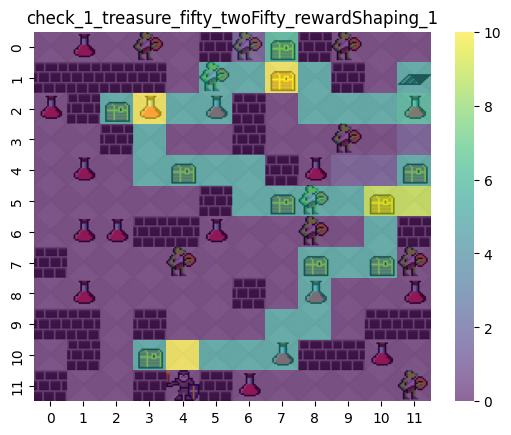

In [47]:
lvl='check_1'
gen_data_and_img(lvl=lvl,reward_scheme='fifty_twoFifty', play_style='treasure',exp_type='rewardShaping_1',path='reward_shaping',img_path=f'./README/resources/md_stages_screenshots/md-{lvl}-v0_step0.jpg')


rewardShaping
check_1_runner_fifty_twoFifty_rewardShaping


/home/alex/anaconda3/envs/test1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/alex/anaconda3/envs/test1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


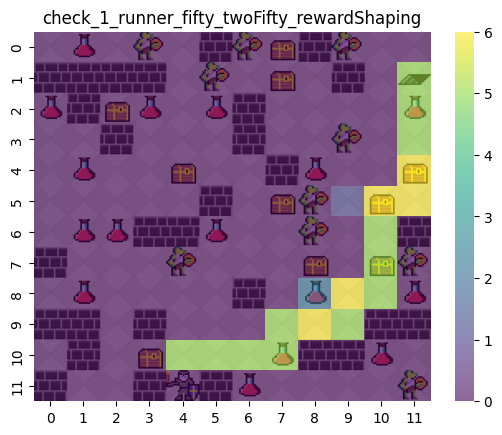

In [50]:
gen_data_and_img(lvl=lvl,reward_scheme='fifty_twoFifty', play_style='runner',exp_type='rewardShaping',path='reward_shaping',img_path=f'./README/resources/md_stages_screenshots/md-{lvl}-v0_step0.jpg')


rewardShaping
check_1_potion_fifty_twoFifty_rewardShaping


/home/alex/anaconda3/envs/test1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/alex/anaconda3/envs/test1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


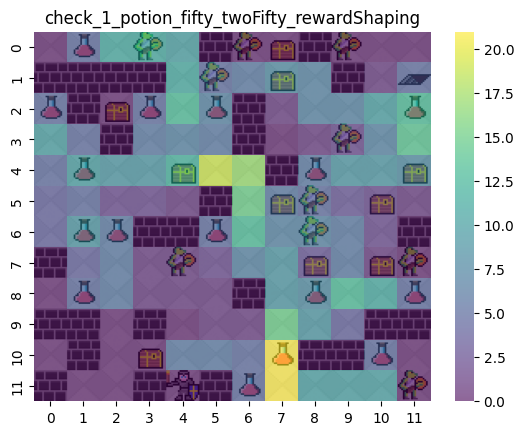

In [51]:
gen_data_and_img(lvl=lvl,reward_scheme='fifty_twoFifty', play_style='potion',exp_type='rewardShaping',path='reward_shaping',img_path=f'./README/resources/md_stages_screenshots/md-{lvl}-v0_step0.jpg')


rewardShaping
holmgard_9_killer_fifty_twoFifty_rewardShaping


/home/alex/anaconda3/envs/test1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/alex/anaconda3/envs/test1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


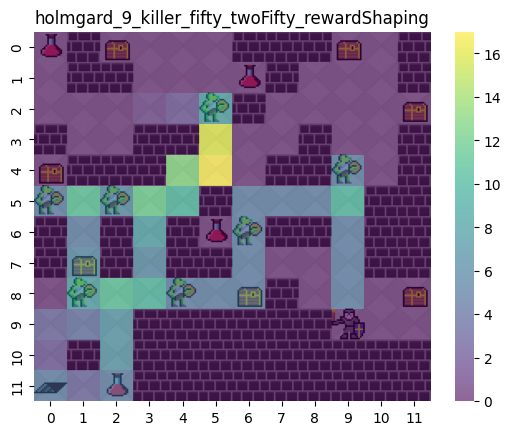

In [52]:
lvl='holmgard_9'
gen_data_and_img(lvl=lvl,reward_scheme='fifty_twoFifty', play_style='killer',exp_type='rewardShaping',path='reward_shaping',img_path=f'./README/resources/md_stages_screenshots/md-{lvl}-v0_step0.jpg')


# Shap Stuff

## Get data

## load model into shap


In [41]:
import shap
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
import imageio
# %pip install ipywidgets
import ipywidgets as widgets
from PIL import Image
from tqdm import tqdm

shap.initjs()
obs_names = ['dist_monster', 'dist_treaure', 'safe_dist_teasure', 'dist_potion', 'safe_dist_potion', 'dist_exit', 'safe_dist_exit', 'HP']
class_names = ['MONSTER','TREASURE','TREASURE_SAFELY','POTION','POTION_SAFELY','EXIT','EXIT_SAFELY']

transdict = {0:'.',
             1:'#',
             2:'T',
             3:'P',
             4:'M',
             5:'E',
             6:'S'}

def print_instance(grid):
    grid =np.asarray(grid)
    # print(np.array([transdict.get(i, -1) for i in range(grid.min(), grid.max() + 1)]))
    func =np.vectorize(lambda x: transdict[x])
    grid = func(grid)
    print('\n'.join(''.join(str(cell) for cell in row) for row in grid))

In [42]:
def convert_fig(plt):
    # Get the figure and its axes
    fig = plt.gcf()
    axes = plt.gca()

    # Draw the content
    fig.canvas.draw()

    # Get the RGB values
    rgb = fig.canvas.tostring_rgb()

    # Get the width and height of the figure
    width, height = fig.canvas.get_width_height()

    # Convert the RGB values to a PIL Image
    img = Image.frombytes('RGB', (width, height), rgb)
    img_array = np.array(img)
    return img_array


class sb3Wrapper(nn.Module):
    def __init__(self, model):
        super(sb3Wrapper,self).__init__()
        self.extractor = model.policy.mlp_extractor
        self.policy_net = model.policy.mlp_extractor.policy_net
        self.action_net = model.policy.action_net

    def forward(self,x):
        x = self.policy_net(x)
        x = self.action_net(x)
        return x

def shap_behaviour(lvl,play_style,reward_scheme,exp_type,path):
    #generate data
    data =gen_data(lvl=lvl, play_style=play_style, reward_scheme=reward_scheme, exp_type=exp_type, path=path)
    df = pd.DataFrame(data, columns=['experiment','level','run','x','y','grid','play_style','action','observation','done','reward','info','grid_rows','grid_columns'])
    print(df['action'].value_counts())
    df_to_analyse = df[df['action'].isin({f'{play_style.upper()}', f'{play_style.upper()}_SAFELY'})]
    # print(df_to_analyse[['action', 'observation']])
    print(df[['action','observation']])
    #load PPO model
    model_path = f"logs/{path}/{lvl}_{play_style}_{reward_scheme}_{exp_type}/best_model/best_model"
    model = PPO.load(model_path, device='cuda')
    state_log = np.array(df['observation'].values.tolist())
    data =torch.FloatTensor(state_log).to('cuda')
    model = sb3Wrapper(model)
    explainer = shap.DeepExplainer(model, data)
    # explainer=shap.KernelExplainer(model.policy.,state_log)
    shap_vals= explainer.shap_values(data)

    return explainer, shap_vals, data, df

def shap_behaviour_gif(lvl,play_style,reward_scheme,exp_type,path,gif_type):
    #generate data
    data =gen_data(lvl=lvl, play_style=play_style, reward_scheme=reward_scheme, exp_type=exp_type, path=path)
    df = pd.DataFrame(data, columns=['experiment','level','run','x','y','grid','play_style','action','observation','done','reward','info','grid_rows','grid_columns'])
    print(df['action'].value_counts())
    df_to_analyse = df[df['action'].isin({f'{play_style.upper()}', f'{play_style.upper()}_SAFELY'})]
    # print(df_to_analyse[['action', 'observation']])
    print(df[['action','observation']])
    #load PPO model

    model_path = f"logs/{path}/{lvl}_{play_style}_{reward_scheme}_{exp_type}/best_model/best_model"
    exp_name = f"{lvl}_{play_style}_{reward_scheme}_{exp_type}"
    model = PPO.load(model_path, device='cuda')
    state_log = np.array(df['observation'].values.tolist())
    data =torch.FloatTensor(state_log).to('cuda')
    model = sb3Wrapper(model)

    images = []
    if gif_type == "state_inc":
        for i in tqdm(range(len(state_log))):
            # print(data[:i+1,:])
            # data = torch.FloatTensor(state_log).to('cuda')
            cur_data = data[:i+1,:]
            explainer = shap.DeepExplainer(model, cur_data)
            shap_vals= explainer.shap_values(cur_data)
            shap.summary_plot(shap_vals,cur_data, feature_names=obs_names,class_names= class_names,plot_type='bar', show =False)
            plt.title(f'{exp_name}\n states used: {i}')
            images.append(convert_fig(plt))
            plt.clf()
    elif gif_type== "play":
        for i in tqdm(range(len(state_log))):
            cur_data = data[i]
            explainer = shap.DeepExplainer(model, cur_data)
            shap_vals= explainer.shap_values(cur_data)
            action = df['action'].iloc[i]
            shap.force_plot(shap_vals,cur_data, feature_names=obs_names,class_names= class_names,plot_type='bar', show =False)
            plt.title(f'{exp_name}\n states used: {i}')
            images.append(convert_fig(plt))
            plt.clf()
        
    print(images)
    imageio.mimsave(f'./shap/shap_gifs/{exp_name}.gif',images,format='GIF')

    return explainer, shap_vals, data, df

shap.initjs()

explainer, shap_values, data, df =shap_behaviour_gif("policy_1", play_style="treasure", reward_scheme="fifty_twoFifty", exp_type="rewardShaping_6", path="reward_shaping",gif_type="state_inc")
# shap.summary_plot(shap_values,data, feature_names=obs_names,plot_type='bar')



rewardShaping_6
policy_1_treasure_fifty_twoFifty_rewardShaping_6
TREASURE_SAFELY    122
TREASURE           101
EXIT_SAFELY         20
EXIT                18
POTION_SAFELY       11
POTION               9
MONSTER              2
Name: action, dtype: int64
              action                     observation
0           TREASURE        [4, 4, 4, 6, 6, 8, 8, 5]
1           TREASURE        [3, 3, 3, 5, 5, 7, 7, 5]
2           TREASURE        [4, 2, 2, 6, 6, 8, 8, 5]
3    TREASURE_SAFELY        [5, 1, 1, 7, 7, 9, 9, 5]
4           TREASURE      [6, 0, 0, 8, 8, 10, 10, 5]
..               ...                             ...
278      EXIT_SAFELY  [4, 1000, 1000, 4, 4, 2, 2, 5]
279           POTION  [3, 1000, 1000, 3, 3, 3, 3, 5]
280             EXIT  [4, 1000, 1000, 4, 4, 2, 2, 5]
281      EXIT_SAFELY  [5, 1000, 1000, 4, 4, 1, 1, 5]
282             EXIT  [5, 1000, 1000, 3, 3, 0, 0, 5]

[283 rows x 2 columns]


100%|██████████| 283/283 [26:34<00:00,  5.63s/it]


[array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]

<Figure size 800x470 with 0 Axes>

In [105]:

def get_row_info(df, row):
    action = df['action'][row]
    obs = df['observation'][row]
    print(f"Action: {action}")
    print(f"Observation: {obs}")
    print_instance(df['grid'][row])
    return action, obs

row=2
action, obs=get_row_info(df, row)
# shap.force_plot(explainer.expected_value[class_names.index(action)],shap_values[class_names.index(action)][row],feature_names=obs_names)
# print(explainer())
shap.plots.waterfall(explainer)



Action: TREASURE_SAFELY
Observation: [4 2 2 6 6 8 8 5]
T......T.T....T
.######.######.
T#M....M..M.M#T
.#.####.####.#.
T#M#P..P..P#M#.
.#.#.##.##.#.#.
S#M#P#...#P#.#.
.......E..P.M.T
.#.#.#...#.#.#.
.#.#.##.##P#M#.
.#.#....P.P#.#T
.#.####.####.#.
.#......M..MM#T
.######T######.
...........T..T


AttributeError: 'Deep' object has no attribute 'base_values'

rewardShaping
policy_1_killer_fifty_twoFifty_rewardShaping


WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


MONSTER            171
EXIT_SAFELY         35
TREASURE_SAFELY     24
TREASURE            21
POTION              20
EXIT                19
POTION_SAFELY       15
Name: action, dtype: int64
              action                     observation
0            MONSTER    [4, 4, 4, 6, 6, 8, 8, 10000]
1            MONSTER    [3, 3, 3, 5, 5, 7, 7, 10000]
2            MONSTER    [2, 4, 4, 4, 4, 6, 6, 10000]
3            MONSTER    [1, 5, 5, 3, 3, 5, 5, 10000]
4            MONSTER     [0, 6, 6, 4, 4, 6, 6, 9990]
..               ...                             ...
300    POTION_SAFELY  [1000, 7, 7, 2, 2, 4, 4, 9880]
301      EXIT_SAFELY  [1000, 8, 8, 1, 1, 3, 3, 9880]
302      EXIT_SAFELY  [1000, 9, 9, 2, 2, 2, 2, 9880]
303  TREASURE_SAFELY  [1000, 8, 8, 3, 3, 1, 1, 9880]
304             EXIT  [1000, 7, 7, 3, 3, 0, 0, 9880]

[305 rows x 2 columns]


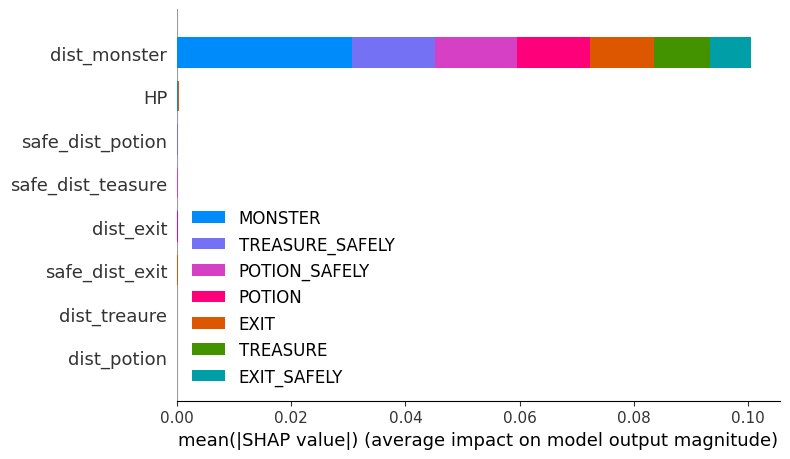

In [49]:
explainer, shap_values, data, df =shap_behaviour("policy_1", play_style="killer", reward_scheme="fifty_twoFifty", exp_type="rewardShaping", path="reward_shaping")
shap.summary_plot(shap_values,data, feature_names=obs_names, class_names=class_names,plot_type='bar')

rewardShaping
policy_1_potion_fifty_twoFifty_rewardShaping


WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


POTION_SAFELY      59
POTION             57
EXIT                9
EXIT_SAFELY         8
MONSTER             2
TREASURE            2
TREASURE_SAFELY     2
Name: action, dtype: int64
            action                     observation
0           POTION        [4, 4, 4, 6, 6, 8, 8, 5]
1    POTION_SAFELY        [3, 3, 3, 5, 5, 7, 7, 5]
2    POTION_SAFELY        [2, 4, 4, 4, 4, 6, 6, 5]
3           POTION        [1, 5, 5, 3, 3, 5, 5, 5]
4           POTION        [2, 6, 6, 2, 2, 4, 4, 5]
..             ...                             ...
134  POTION_SAFELY        [4, 4, 4, 0, 0, 4, 4, 5]
135    EXIT_SAFELY  [3, 3, 3, 1000, 1000, 3, 3, 5]
136    EXIT_SAFELY  [4, 4, 4, 1000, 1000, 2, 2, 5]
137           EXIT  [5, 5, 5, 1000, 1000, 1, 1, 5]
138           EXIT  [5, 6, 6, 1000, 1000, 0, 0, 5]

[139 rows x 2 columns]


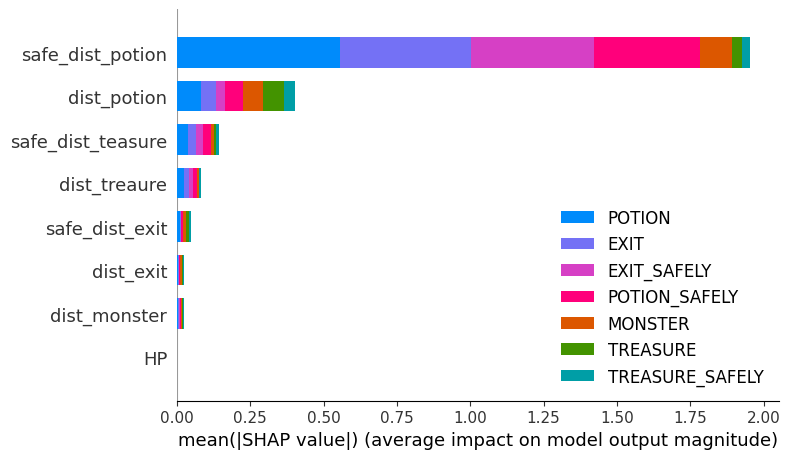

In [86]:
explainer, shap_values, data, df =shap_behaviour("policy_1", play_style="potion", reward_scheme="fifty_twoFifty", exp_type="rewardShaping", path="reward_shaping")
shap.summary_plot(shap_values,data, feature_names=obs_names, class_names=class_names,plot_type='bar')

rewardShaping_1
policy_1_runner_fifty_twoFifty_rewardShaping_1


WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


EXIT             25
EXIT_SAFELY      21
TREASURE          1
POTION            1
POTION_SAFELY     1
Name: action, dtype: int64
           action               observation
0     EXIT_SAFELY  [4, 4, 4, 6, 6, 8, 8, 5]
1     EXIT_SAFELY  [3, 3, 3, 5, 5, 7, 7, 5]
2     EXIT_SAFELY  [2, 4, 4, 4, 4, 6, 6, 5]
3            EXIT  [1, 5, 5, 3, 3, 5, 5, 5]
4     EXIT_SAFELY  [2, 6, 6, 2, 2, 4, 4, 5]
5     EXIT_SAFELY  [3, 7, 7, 1, 1, 3, 3, 5]
6     EXIT_SAFELY  [4, 8, 8, 2, 2, 2, 2, 5]
7        TREASURE  [3, 7, 7, 1, 1, 3, 3, 5]
8            EXIT  [4, 8, 8, 2, 2, 2, 2, 5]
9     EXIT_SAFELY  [5, 7, 7, 3, 3, 1, 1, 5]
10           EXIT  [5, 6, 6, 3, 3, 0, 0, 5]
11    EXIT_SAFELY  [4, 4, 4, 6, 6, 8, 8, 5]
12         POTION  [3, 3, 3, 5, 5, 7, 7, 5]
13           EXIT  [2, 4, 4, 4, 4, 6, 6, 5]
14    EXIT_SAFELY  [1, 5, 5, 3, 3, 5, 5, 5]
15           EXIT  [2, 6, 6, 2, 2, 4, 4, 5]
16           EXIT  [3, 7, 7, 1, 1, 3, 3, 5]
17           EXIT  [4, 8, 8, 2, 2, 2, 2, 5]
18    EXIT_SAFELY  [5, 7, 7, 3, 3, 1,

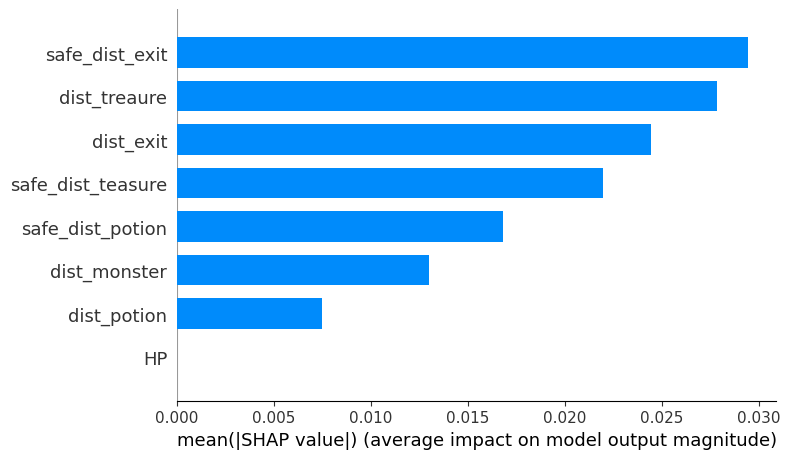

In [84]:
explainer, shap_values, data, df =shap_behaviour("policy_1", play_style="runner", reward_scheme="fifty_twoFifty", exp_type="rewardShaping_1", path="reward_shaping")
shap.summary_plot(shap_values[6],data, feature_names=obs_names, class_names=class_names, plot_type='bar')

## Holmgard_9

rewardShaping
holmgard_9_treasure_fifty_twoFifty_rewardShaping


WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


TREASURE           90
EXIT_SAFELY        40
TREASURE_SAFELY    15
Name: action, dtype: int64
              action                   observation
0    TREASURE_SAFELY  [6, 2, 2, 8, 20, 16, 22, 40]
1           TREASURE  [7, 1, 1, 9, 21, 17, 23, 40]
2           TREASURE  [6, 0, 0, 8, 20, 16, 22, 40]
3           TREASURE  [5, 6, 6, 7, 19, 15, 21, 40]
4           TREASURE  [4, 5, 5, 6, 18, 14, 20, 40]
..               ...                           ...
140      EXIT_SAFELY   [4, 15, 16, 4, 4, 4, 4, 10]
141      EXIT_SAFELY   [5, 16, 17, 3, 3, 3, 3, 10]
142      EXIT_SAFELY   [6, 17, 18, 4, 4, 2, 2, 10]
143      EXIT_SAFELY   [7, 18, 19, 3, 3, 1, 1, 10]
144      EXIT_SAFELY   [8, 19, 20, 2, 2, 0, 0, 10]

[145 rows x 2 columns]


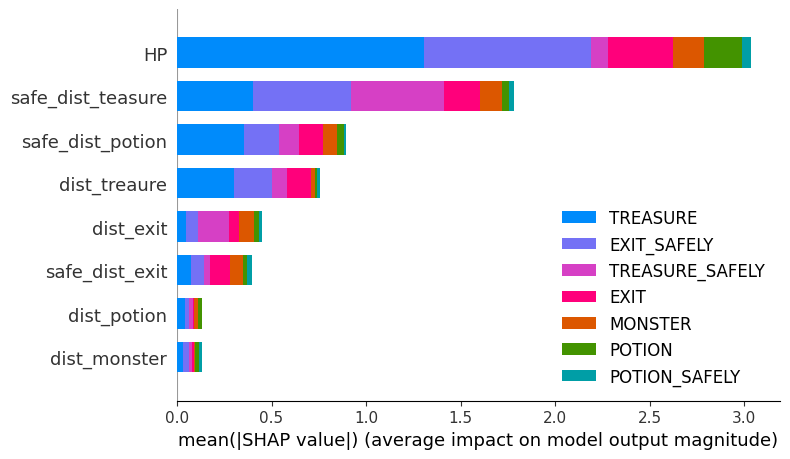

In [63]:
explainer, shap_values, data, df =shap_behaviour("holmgard_9", play_style="treasure", reward_scheme="fifty_twoFifty", exp_type="rewardShaping", path="reward_shaping")
shap.summary_plot(shap_values,data, feature_names=obs_names, class_names=class_names,plot_type='bar')

rewardShaping
holmgard_9_killer_fifty_twoFifty_rewardShaping


WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


MONSTER          151
EXIT              75
TREASURE          11
EXIT_SAFELY       10
POTION             7
POTION_SAFELY      7
Name: action, dtype: int64
      action                         observation
0    MONSTER     [4, 2, 2, 6, 18, 14, 20, 10000]
1    MONSTER     [3, 3, 3, 5, 17, 13, 19, 10000]
2       EXIT     [3, 3, 3, 4, 18, 12, 20, 10000]
3    MONSTER     [2, 2, 2, 3, 19, 11, 21, 10000]
4    MONSTER     [1, 1, 1, 2, 20, 10, 22, 10000]
..       ...                                 ...
256     EXIT      [1000, 7, 7, 2, 2, 4, 4, 9930]
257   POTION      [1000, 8, 8, 1, 1, 3, 3, 9930]
258     EXIT      [1000, 9, 9, 0, 0, 2, 2, 9940]
259     EXIT  [1000, 10, 10, 11, 11, 1, 1, 9940]
260     EXIT    [1000, 9, 9, 12, 12, 0, 0, 9940]

[261 rows x 2 columns]


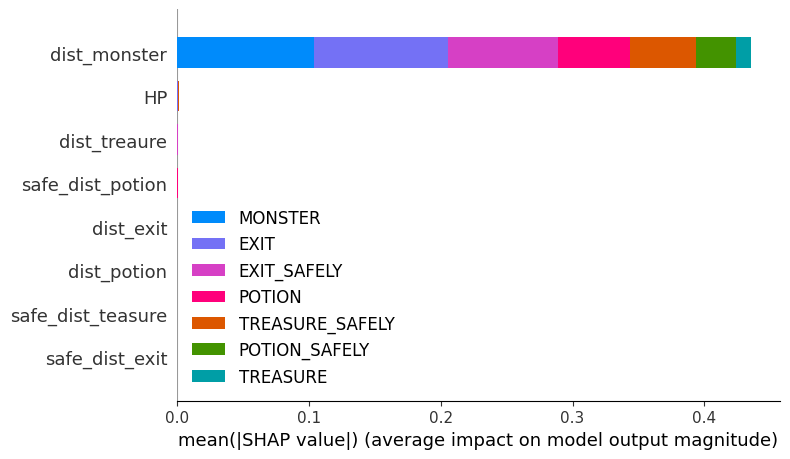

In [64]:
explainer, shap_values, data, df =shap_behaviour("holmgard_9", play_style="killer", reward_scheme="fifty_twoFifty", exp_type="rewardShaping", path="reward_shaping")
shap.summary_plot(shap_values,data, feature_names=obs_names, class_names=class_names,plot_type='bar')

rewardShaping
holmgard_9_potion_fifty_twoFifty_rewardShaping


WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


POTION             210
EXIT                 8
POTION_SAFELY        6
EXIT_SAFELY          4
TREASURE_SAFELY      1
Name: action, dtype: int64
            action                       observation
0           POTION      [4, 2, 2, 6, 18, 14, 20, 40]
1           POTION      [4, 3, 3, 5, 19, 13, 21, 40]
2           POTION      [3, 3, 3, 4, 18, 12, 20, 40]
3           POTION      [2, 2, 2, 3, 19, 11, 21, 40]
4           POTION      [1, 1, 1, 2, 20, 10, 22, 40]
..             ...                               ...
224         POTION        [2, 3, 13, 2, 2, 4, 4, 40]
225         POTION        [3, 4, 14, 1, 1, 3, 3, 40]
226  POTION_SAFELY        [4, 5, 15, 0, 0, 2, 2, 40]
227           EXIT  [5, 6, 16, 1000, 1000, 1, 1, 40]
228           EXIT  [4, 5, 17, 1000, 1000, 0, 0, 40]

[229 rows x 2 columns]


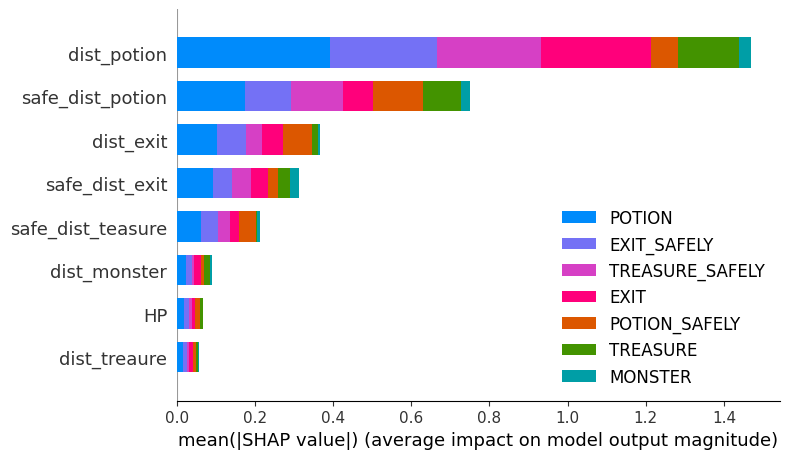

In [65]:
explainer, shap_values, data, df =shap_behaviour("holmgard_9", play_style="potion", reward_scheme="fifty_twoFifty", exp_type="rewardShaping", path="reward_shaping")
shap.summary_plot(shap_values,data, feature_names=obs_names, class_names=class_names,plot_type='bar')

rewardShaping
holmgard_9_runner_fifty_twoFifty_rewardShaping


WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


EXIT             62
EXIT_SAFELY      11
POTION_SAFELY     2
Name: action, dtype: int64
         action                     observation
0          EXIT    [4, 2, 2, 6, 18, 14, 20, 40]
1          EXIT    [4, 3, 3, 5, 19, 13, 21, 40]
2          EXIT    [3, 3, 3, 4, 18, 12, 20, 40]
3          EXIT    [2, 2, 2, 3, 19, 11, 21, 40]
4          EXIT    [1, 1, 1, 2, 20, 10, 22, 40]
..          ...                             ...
70         EXIT      [2, 3, 12, 2, 2, 4, 4, 30]
71  EXIT_SAFELY      [3, 4, 13, 1, 1, 3, 3, 30]
72         EXIT      [4, 5, 14, 0, 0, 2, 2, 40]
73  EXIT_SAFELY  [5, 6, 15, 11, 1000, 1, 1, 40]
74  EXIT_SAFELY  [4, 5, 16, 12, 1000, 0, 0, 40]

[75 rows x 2 columns]


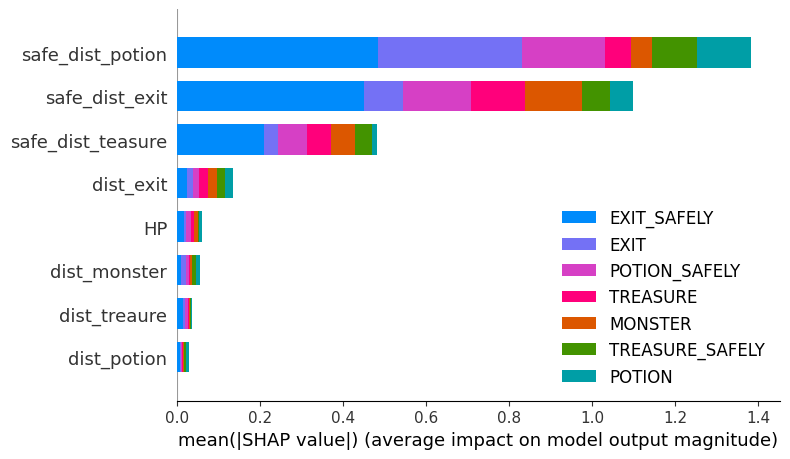

In [66]:
explainer, shap_values, data, df =shap_behaviour("holmgard_9", play_style="runner", reward_scheme="fifty_twoFifty", exp_type="rewardShaping", path="reward_shaping")
shap.summary_plot(shap_values,data, feature_names=obs_names, class_names=class_names,plot_type='bar')

SteprewardShaping
holmgard_9_treasure_fifty_twoFiftytwo_SteprewardShaping


WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


TREASURE_SAFELY    178
TREASURE           134
EXIT_SAFELY        102
POTION_SAFELY       18
EXIT                14
POTION               4
MONSTER              3
Name: action, dtype: int64
              action                        observation
0    TREASURE_SAFELY       [6, 2, 2, 8, 20, 16, 22, 40]
1    TREASURE_SAFELY       [7, 1, 1, 9, 21, 17, 23, 40]
2    TREASURE_SAFELY       [6, 0, 0, 8, 20, 16, 22, 40]
3    TREASURE_SAFELY       [5, 6, 6, 7, 19, 15, 21, 40]
4    TREASURE_SAFELY       [4, 5, 5, 6, 18, 14, 20, 40]
..               ...                                ...
448      EXIT_SAFELY    [2, 1000, 1000, 2, 2, 4, 4, 10]
449      EXIT_SAFELY    [3, 1000, 1000, 1, 1, 3, 3, 10]
450      EXIT_SAFELY    [4, 1000, 1000, 0, 0, 2, 2, 20]
451             EXIT  [5, 1000, 1000, 11, 15, 1, 1, 20]
452      EXIT_SAFELY  [4, 1000, 1000, 12, 16, 0, 0, 20]

[453 rows x 2 columns]


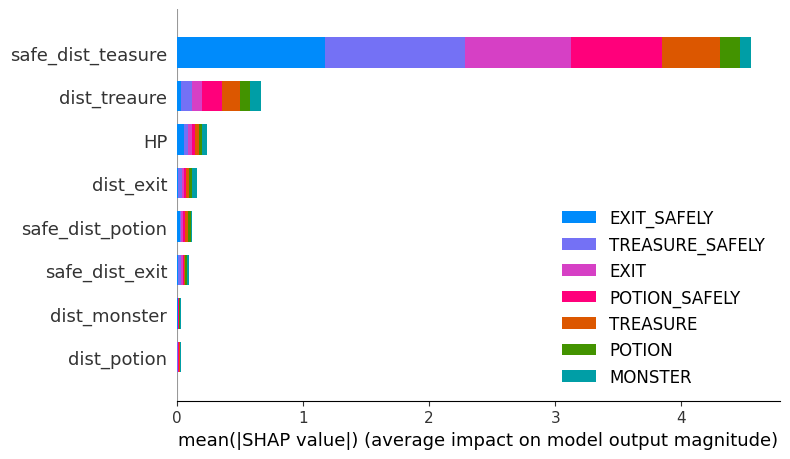

In [71]:
explainer, shap_values, data, df =shap_behaviour("holmgard_9", play_style="treasure", reward_scheme="fifty_twoFiftytwo", exp_type="SteprewardShaping", path="reward_shaping_part2")
shap.summary_plot(shap_values,data, feature_names=obs_names, class_names=class_names,plot_type='bar')